#Test Assignment for the AI Engineer Position

#Task statement

### Objective
Develop and train a neural network to control the landing of a lunar module in the [LunarLander-v2](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) simulation using the OpenAI Gym library. The model should successfully manage the landing of the module, maximizing the total score obtained.

###Tasks:

1. Research: Study the LunarLander-v2 environment in OpenAI Gym and determine what input and output data are necessary for the successful training of the model.

2. Model Development: Create a neural network model that incorporates at least one recurrent layer (RNN) to process sequences of actions and a transformer to analyze the states of the environment. It's crucial to ensure that the model can adapt to the dynamics of landing control.

3. Training: Implement the training process for the model using deep reinforcement learning approaches. Optimize the network parameters to achieve the best possible result in controlling the lunar module's landing.

4. Testing and Evaluation: Conduct a series of tests to evaluate the effectiveness of the model. Analyze the results and suggest possible ways to improve the model.

###Implementation Requirements:

- The code must be executed in Google Colab to ensure access to computational resources and facilitate collaborative work.
- The entire training process should be documented and accompanied by comments in the code to ease the understanding of the workflow.
- A report describing the chosen model architecture, training approaches, and an analysis of the results must be provided.


###Evaluation Criteria:

- The correctness and efficiency of the proposed model.
- The quality and clarity of the code.
- The depth of the analysis of the obtained results and the proposed ways to improve the model.

## Analysis of the task

### Model Development requirement limitations



> Create a neural network model that incorporates at least one recurrent layer (RNN) to process sequences of actions and a transformer to analyze the states of the environment.



####Limitations of Separate Networks:

* **Information Bottleneck**: Separating actions and states into distinct networks creates an information bottleneck. The RNN processing actions wouldn't directly interact with the state analysis from the transformer, potentially hindering the learning process.
* **Redundancy**: Both networks might end up learning similar features from the environment, leading to redundancy and potentially wasted computational resources.

####Alternative Approaches:

* **RNN with Transformer Attention**.
This approach incorporates a transformer-based attention mechanism within the RNN.
The RNN processes the sequence of actions, and at each step, the attention mechanism focuses on relevant parts of the state from the transformer's output.
This allows the RNN to consider both the action history and the most relevant aspects of the current state for decision-making.

*  **Hierarchical Reinforcement Learning**. This approach uses a hierarchical structure with two separate policies.
A high-level policy (transformer) analyzes the overall state and sets high-level goals.
A low-level policy (an RNN) takes actions based on the current state and the high-level goals communicated by the first policy.
This allows for a separation of concerns, with the transformer focusing on strategic goals and the RNN handling the fine-grained control based on the actions and current state.

* **Anything else?** Let's take a look at the environment characteristics.

## LunarLander-v2 environment characteristics

* fully obserwable
* dense reward
* discrete action space (by default)

In such a simple environment following approaches applicable to provide efficient solution:
* Value-Based Methods: Q-Learning (QL), Deep Q-Networks (DQN), Prioritized Experience Replay (PER)
* Policy-Based Methods: Proximal Policy Optimization (PPO), Actor-Critic (A3C, A2C)
* Hybrid Methods like Dueling DQN

In term effiency for such task DQN, Dueling DQN and Actor-Critic aproaches seems reasonable.

## Refinement of model requirements

But according to the task RNN and even Transformer usage is mandatory that is reasonable for more complex partially observable environments. Assume additional support partially observable environments is also mandatory for target solution.

## Possible solutions:
* Deep Reccurent Q-Network (DRQN). Based on evaluation results can be improved with Transformer Attention.
* Hierarchical model (Actor-Critic (with RNN) and Transformer)

According to refined requirements DRQN have potential benefits againts a Hierarchical model:
* **Simplicity** DRQN is a single, unified architecture that combines deep Q-learning with recurrent neural networks. In contrast, the combination of A2C-RNN and a Transformer model involves two separate networks with different architectures and learning objectives, which may increase the complexity of training and deployment.
* **Sample efficiency**: DRQN is an off-policy algorithm that can leverage experience replay, which can lead to improved sample efficiency compared to on-policy algorithms like A2C.
* **Temporal dependencies**: Both DRQN and the proposed combination of A2C-RNN and a Transformer model can capture temporal dependencies in the environment using recurrent neural networks (RNNs) or self-attention mechanisms, respectively. However, DRQN's use of an RNN is more straightforward and directly aligned with the task of capturing temporal dependencies environment.
* **Proven performance**: DRQN has been successfully applied to various reinforcement learning tasks with fully observable environments, dense rewards, and discrete action spaces, such as Atari games and other benchmark tasks. It has demonstrated competitive performance and has been extensively studied and refined in the literature.
* **Computational efficiency**: While the computational requirements may vary, DRQN generally has a more straightforward architecture compared to the combination of A2C-RNN and a Transformer model. This could potentially lead to more efficient training and inference, especially in resource-constrained environments.

# Deep Reccurent Q-Network (DRQN) implementation

##Install and import the necessary packages

In [ ]:
!sudo apt-get install -y swig --quiet
!pip install -q swig
!pip install -q gymnasium[box2d]

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import sys
from typing import Dict, List, Tuple

from collections import namedtuple
import gym
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Q-Network architecture with LSTM layer


In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_space=None, action_space=None, hidden_space=64):
        """
        Initialize the Q-network with given parameters.

        Args:
            state_space (int): Size of the state space.
            action_space (int): Size of the action space.
            hidden_space (int, optional): Size of the hidden layer. Defaults to 64.
        """
        super(QNetwork, self).__init__()
        # Space size check
        assert state_space is not None, "None state_space input: state_space should be selected."
        assert action_space is not None, "None action_space input: action_space should be selected."

        self.hidden_space = hidden_space
        self.state_space = state_space
        self.action_space = action_space

        # Network structure
        self.linear1 = nn.Linear(self.state_space, self.hidden_space)
        self.lstm = nn.LSTM(self.hidden_space, self.hidden_space, batch_first=True)
        self.linear2 = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        """
        Define the forward pass of the model.

        Args:
            x (Tensor): The input data.
            h (Tensor): Hidden state.
            c (Tensor): Cell state.

        Returns:
            tuple: Output of the network, new hidden state, new cell state.
        """
        x = F.relu(self.linear1(x))
        x, (new_h, new_c) = self.lstm(x, (h, c))
        x = self.linear2(x)
        return x, new_h, new_c

    def sample_action(self, obs, h, c, epsilon):
        """
        Sample an action using epsilon-greedy policy.

        Args:
            obs (Tensor): Current observation.
            h (Tensor): Hidden state.
            c (Tensor): Cell state.
            epsilon (float): Probability of choosing a random action.

        Returns:
            tuple: Chosen action, new hidden state, new cell state.
        """
        output = self.forward(obs, h, c)
        if random.random() < epsilon:
            action = random.randint(0, self.action_space - 1)
        else:
            action = output[0].argmax().item()
        return action, output[1], output[2]

    def init_hidden_state(self, batch_size, training=None):
        """
        Initialize hidden and cell states.

        Args:
            batch_size (int): The size of the batch.
            training (bool): Whether the initialization is for training.

        Returns:
            tuple: Initial hidden state, initial cell state.
        """
        assert training is not None, "training step parameter should be determined"
        if training:
            return (torch.zeros(1, batch_size, self.hidden_space),
                    torch.zeros(1, batch_size, self.hidden_space))
        return (torch.zeros(1, 1, self.hidden_space),
                torch.zeros(1, 1, self.hidden_space))

##Memory of agent

In [ ]:
class EpisodeMemory:
   """
   Episode memory for recurrent agent.

   This class is a memory buffer for storing and sampling episodes from an agent's experience.
   It is designed for use with recurrent neural networks, allowing for variable-length episodes
   and sampling with a lookup step.

   Attributes:
       max_epi_num (int): The maximum number of episodes to store in memory.
       max_epi_len (int): The maximum length of an episode that can be stored.
       batch_size (int): The number of episodes to sample per batch.
       lookup_step (int or None): The lookup step size for sampling episodes. If None,
           episodes are sampled without a lookup step.

   Methods:
       put(episode): Add an episode to the memory buffer.
       sample(): Sample a batch of episodes from the memory buffer, with optional lookup step.
       __len__(): Get the number of episodes currently stored in the memory buffer.
   """

   def __init__(self, max_epi_num=100, max_epi_len=500, batch_size=1, lookup_step=None):
       """
       Initialize the EpisodeMemory object.

       Args:
           max_epi_num (int): The maximum number of episodes to store in memory.
           max_epi_len (int): The maximum length of an episode that can be stored.
           batch_size (int): The number of episodes to sample per batch.
           lookup_step (int or None): The lookup step size for sampling episodes. If None,
               episodes are sampled without a lookup step.
       """
       self.max_epi_num = max_epi_num
       self.max_epi_len = max_epi_len
       self.batch_size = batch_size
       self.lookup_step = lookup_step
       self.memory = collections.deque(maxlen=self.max_epi_num)

   def put(self, episode):
       """
       Add an episode to the memory buffer.

       Args:
           episode: An episode to be added to the memory buffer.
       """
       self.memory.append(episode)

   def sample(self):
       """
       Sample a batch of episodes from the memory buffer, with optional lookup step.

       Returns:
           sampled_buffer (list): A list of sampled episodes.
           sequence_length (int): The length of the sampled sequences.
       """
       sampled_buffer = []
       sampled_episodes = random.sample(self.memory, self.batch_size)
       min_step = self.max_epi_len

       # Find the minimum episode length among the sampled episodes
       for episode in sampled_episodes:
           min_step = min(min_step, len(episode))

       # Sample episodes with lookup step or minimum step size
       for episode in sampled_episodes:
           if min_step > self.lookup_step:
               # Sample buffer with lookup_step size
               idx = np.random.randint(0, len(episode) - self.lookup_step + 1)
               sample = episode.sample(lookup_step=self.lookup_step, idx=idx)
               sampled_buffer.append(sample)
           else:
               # Sample buffer with minimum step size
               idx = np.random.randint(0, len(episode) - min_step + 1)
               sample = episode.sample(lookup_step=min_step, idx=idx)
               sampled_buffer.append(sample)

       return sampled_buffer, len(sampled_buffer[0]['obs'])  # buffers, sequence_length

   def __len__(self):
       """
       Get the number of episodes currently stored in the memory buffer.

       Returns:
           int: The number of episodes in the memory buffer.
       """
       return len(self.memory)

In [ ]:
class EpisodeBuffer:
    """A simple numpy replay buffer."""

    def __init__(self):
        self.obs = []
        self.action = []
        self.reward = []
        self.next_obs = []
        self.done = []

    def put(self, transition):
        self.obs.append(transition[0])
        self.action.append(transition[1])
        self.reward.append(transition[2])
        self.next_obs.append(transition[3])
        self.done.append(transition[4])

    def sample(self, lookup_step=None, idx=None) -> Dict[str, np.ndarray]:
        obs = np.array(self.obs)
        action = np.array(self.action)
        reward = np.array(self.reward)
        next_obs = np.array(self.next_obs)
        done = np.array(self.done)

        obs = obs[idx:idx+lookup_step]
        action = action[idx:idx+lookup_step]
        reward = reward[idx:idx+lookup_step]
        next_obs = next_obs[idx:idx+lookup_step]
        done = done[idx:idx+lookup_step]

        return dict(obs=obs,
                    acts=action,
                    rews=reward,
                    next_obs=next_obs,
                    done=done)

    def __len__(self) -> int:
        return len(self.obs)

##Training procedure

In [ ]:
def train(q_network=None, target_q_network=None, episode_memory=None, device=None, optimizer=None,
          batch_size=1, learning_rate=1e-3, gamma=0.99):
    """
    Performs a training step for the Q-network.

    Args:
        q_network (nn.Module): The Q-network to be trained.
        target_q_network (nn.Module): The target Q-network used for computing the target values.
        episode_memory (ReplayBuffer): The replay buffer containing the episode samples.
        device (torch.device): The device to perform computations on.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the Q-network.
        batch_size (int): The batch size for training.
        learning_rate (float): The learning rate for the optimizer.
        gamma (float): The discount factor for future rewards.

    Returns:
        None
    """
    assert device is not None, "None Device input: device should be selected."

    # Get batch from replay buffer
    samples, seq_len = episode_memory.sample()

    # Extract observations, actions, rewards, next observations, and dones from the samples
    observations, actions, rewards, next_observations, dones = [], [], [], [], []
    for i in range(batch_size):
        observations.append(samples[i]["obs"])
        actions.append(samples[i]["acts"])
        rewards.append(samples[i]["rews"])
        next_observations.append(samples[i]["next_obs"])
        dones.append(samples[i]["done"])

    observations = np.array(observations)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_observations = np.array(next_observations)
    dones = np.array(dones)

    # Convert to PyTorch tensors and move to the specified device
    observations = torch.FloatTensor(observations.reshape(batch_size, seq_len, -1)).to(device)
    actions = torch.LongTensor(actions.reshape(batch_size, seq_len, -1)).to(device)
    rewards = torch.FloatTensor(rewards.reshape(batch_size, seq_len, -1)).to(device)
    next_observations = torch.FloatTensor(next_observations.reshape(batch_size, seq_len, -1)).to(device)
    dones = torch.FloatTensor(dones.reshape(batch_size, seq_len, -1)).to(device)

    # Compute target Q-values using the target Q-network
    h_target, c_target = target_q_network.init_hidden_state(batch_size=batch_size, training=True)
    q_target, _, _ = target_q_network(next_observations, h_target.to(device), c_target.to(device))
    q_target_max = q_target.max(2)[0].view(batch_size, seq_len, -1).detach()
    targets = rewards + gamma * q_target_max * dones

    # Compute Q-values using the current Q-network
    h, c = q_network.init_hidden_state(batch_size=batch_size, training=True)
    q_out, _, _ = q_network(observations, h.to(device), c.to(device))
    q_a = q_out.gather(2, actions)

    # Compute the loss and update the Q-network
    loss = F.smooth_l1_loss(q_a, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def seed_torch(seed):
    """
    Seeds the PyTorch random number generator with the given seed.
    This ensures reproducibility across different runs.

    Args:
        seed (int): The seed value to use for PyTorch's random number generator.
    """
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        # Turn off benchmark mode to ensure deterministic behavior
        torch.backends.cudnn.benchmark = False
        # Enable deterministic operations for CUDA calculations
        torch.backends.cudnn.deterministic = True

def set_seed(env, seed):
    """
    Sets the seed for different random number generators used in the project.

    Args:
        env: The environment object (e.g., OpenAI Gym environment).
        seed (int): The seed value to use for the random number generators.
    """
    # Seed NumPy random number generator
    np.random.seed(seed)
    # Seed Python's built-in random module
    random.seed(seed)
    # Seed PyTorch's random number generator
    seed_torch(seed)
    # Seed the environment's random number generator (if applicable)
    env.seed(seed)

def save_model(model, path='default.pth'):
    """
    Saves the state dictionary of the given PyTorch model.

    Args:
        model: The PyTorch model object to save.
        path (str, optional): The path to save the model. Default is 'default.pth'.
    """
    # Save the model's state dictionary to the specified path
    torch.save(model.state_dict(), path)

In [ ]:
def train_episode(env, episode_memory, q_network, q_network_target, epsilon, batch_size, max_step, min_epi_num, optimizer,
                 learning_rate, target_update_period, tau):
   """
   Train an episode of the environment using the given Q-network, target Q-network, and memory buffer.

   Args:
       env (gym.Env): The environment to train on.
       episode_memory (ReplayBuffer): Memory buffer to store episode transitions.
       q_network (QNetwork): The Q-network to be optimized.
       q_network_target (QNetwork): The target Q-network used for stable target values.
       epsilon (float): Exploration rate for epsilon-greedy exploration.
       batch_size (int): Batch size for training.
       max_step (int): Maximum number of steps per episode.
       min_epi_num (int): Minimum number of episodes to start training.
       optimizer (torch.optim.Optimizer): Optimizer for the Q-network.
       learning_rate (float): Learning rate for the optimizer.
       target_update_period (int): Number of steps after which the target network is updated.
       tau (float): Soft update coefficient for the target network.

   Returns:
       int: Total score accumulated during the episode.
   """
   s = env.reset()
   obs = s
   done = False
   score = 0
   score_sum = 0
   episode_record = EpisodeBuffer()
   h, c = q_network.init_hidden_state(batch_size=batch_size, training=False)

   for t in range(max_step):
       # Get action
       a, h, c = q_network.sample_action(torch.from_numpy(obs).float().to(device).unsqueeze(0).unsqueeze(0),
                                 h.to(device), c.to(device), epsilon)

       # Do action
       s_prime, r, done, _ = env.step(a)
       obs_prime = s_prime

       # Make data
       done_mask = 0.0 if done else 1.0
       episode_record.put([obs, a, r / 100.0, obs_prime, done_mask])
       obs = obs_prime
       score += r
       score_sum += r

       if len(episode_memory) >= min_epi_num:
           train(q_network, q_network_target, episode_memory, device, optimizer=optimizer, batch_size=batch_size,
                 learning_rate=learning_rate)

       if (t + 1) % target_update_period == 0:
           # Soft update of target network
           for target_param, local_param in zip(q_network_target.parameters(), q_network.parameters()):
               target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

       if done:
           break

   episode_memory.put(episode_record)
   return score_sum

In [ ]:
def train_all(config=None):
    """
    Train a Deep Recurrent Q-Network (DRQN) agent on a gym environment.

    Args:
        config (dict, optional): Configuration parameters for the training process.

    Returns:
        None
    """

    # Set gym environment
    env = gym.make(env_name)

    # Set the seed
    seed = 1
    set_seed(env, seed)

    # Set parameters
    batch_size = config.batch_size # 8
    learning_rate = config.learning_rate # 1e-3
    buffer_len = int(100000)
    min_epi_num = 16 # Start moment to train the Q network
    episodes = 5000
    target_update_period = config.target_update_period  # 4
    print_per_iter = target_update_period
    eps_start = 0.1
    eps_end = 0.001
    eps_decay = config.eps_decay # 0.995
    tau = 1e-3
    max_step = 2000

    # DRQN param
    lookup_step = config.lookup_step  # Number of steps to look back for the state representation
    max_epi_len = config.max_epi_len

    # Create Q functions
    q_network = QNetwork(
        state_space=env.observation_space.shape[0],
        action_space=env.action_space.n,
        hidden_space=config.hidden_space
    ).to(device)

    q_network_target = QNetwork(
        state_space=env.observation_space.shape[0],
        action_space=env.action_space.n,
        hidden_space=config.hidden_space
    ).to(device)
    q_network_target.load_state_dict(q_network.state_dict())

    # Set optimizer
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    epsilon = eps_start

    # Initialize episode memory
    episode_memory = EpisodeMemory(
        max_epi_num=100,
        max_epi_len=config.max_epi_len,
        batch_size=batch_size,
        lookup_step=config.lookup_step
    )

    score_sum = 0.0
    best_score = -9_999

    # Train episodes
    for i in range(episodes):
        episode_score_sum = train_episode(
            env, episode_memory, q_network, q_network_target,
            epsilon, batch_size, max_step, min_epi_num,
            optimizer, learning_rate, target_update_period, tau=config.tau
        )
        score_sum += episode_score_sum
        epsilon = max(eps_end, epsilon * eps_decay)  # Linear annealing

        # Print stats and save model each print_per_iter iteration only
        if i % print_per_iter == 0 and i != 0:
            avg_score = score_sum / print_per_iter
            # Print the progress
            print(
                f"Episode: {i}, Score: {avg_score:.1f}, "
                f"Buffer Size: {len(episode_memory)}, Epsilon: {epsilon:.1%}"
            )
            score_sum = 0.0

            # Save model
            last_pth_filename = f"{model_name}_score_{avg_score:.1f}.pth"
            save_model(q_network, last_pth_filename)

            # Memorize best model
            if avg_score > best_score:
                best_score = avg_score
                global best_pth_filename
                best_pth_filename = last_pth_filename


    env.close()

## Training config and execution

Simplified version of code provided to avoid external services dependency.

wandb.ai used to research hyperparameters space. More details available in "Hyperameters tuning" section.

In [ ]:
model_name = "DRQN"
env_name = "LunarLander-v2"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Config = namedtuple('Config', "batch_size eps_decay hidden_space learning_rate lookup_step max_epi_len target_update_period tau")

# best configuration setup after Hyperameters tuning
c = {'batch_size': 2,
'eps_decay': 0.9992,
'hidden_space': 32,
'learning_rate': 0.001,
'lookup_step': 12,
'max_epi_len': 128,
'target_update_period': 3,
'tau': 0.001}

cfg = Config(**c)

In [ ]:
train_all(cfg)

# Top score model evaluation

In [ ]:
best_pth_filename

'DRQN_score_305.7.pth'

In [ ]:
# Set the path for the pre-trained model
pth_path = f'/content/{best_pth_filename}'

# Create the environment
env = gym.make(env_name)

# Initialize the Q-network model
model = QNetwork(
    state_space=env.observation_space.shape[0],  # Input size (state size)
    action_space=env.action_space.n,  # Output size (number of actions)
    hidden_space=cfg.hidden_space,  # Size of the hidden layer
).to(device)

# Load the pre-trained model weights
model.load_state_dict(torch.load(pth_path, map_location=torch.device(device)))

# Set the model to evaluation mode
model.eval()

y = np.array([])
# Run 100 episodes
for i in range(100):
    obs = env.reset()  # Reset the environment and get the initial state

    # Initialize the hidden state for the LSTM
    h, c = model.init_hidden_state(batch_size=cfg.batch_size, training=False)

    score = 0
    done = False

    while not done:
        # Forward pass through the Q-network
        output = model.forward(
            torch.from_numpy(obs).float().to(device).unsqueeze(0).unsqueeze(0),
            h.to(device),
            c.to(device),
        )

        # Get the action with the maximum Q-value
        a, h, c = output[0].argmax().item(), output[1], output[2]

        # Take the action and observe the next state and reward
        s_prime, r, done, _ = env.step(a)

        # Update the score
        score += r

        # Update the state for the next iteration
        obs_prime = s_prime
        obs = obs_prime

        if done:
            print(f"score is {score}, target is 200")
            y = np.append(y, score)
            break

# Close the environment after evaluation
env.close()

score is 263.4399683979593, target is 200
score is 261.3224226533598, target is 200
score is 246.33294162798907, target is 200
score is 233.5951238672963, target is 200
score is 275.41669685050897, target is 200
score is 258.174833616613, target is 200
score is 266.55963399371205, target is 200
score is 258.96141727889096, target is 200
score is 261.53272662205814, target is 200
score is 223.71053847191666, target is 200
score is 219.57849607635487, target is 200
score is 241.42385167009644, target is 200
score is 207.75048725267987, target is 200
score is 272.7260683748383, target is 200
score is 244.26236163978385, target is 200
score is 266.99189213142404, target is 200
score is 238.34064846824995, target is 200
score is 233.1585743424198, target is 200
score is 277.4327538247015, target is 200
score is 246.99133175876517, target is 200
score is 227.70244886135697, target is 200
score is 281.6075778502553, target is 200
score is 202.60800610629283, target is 200
score is 265.8020738

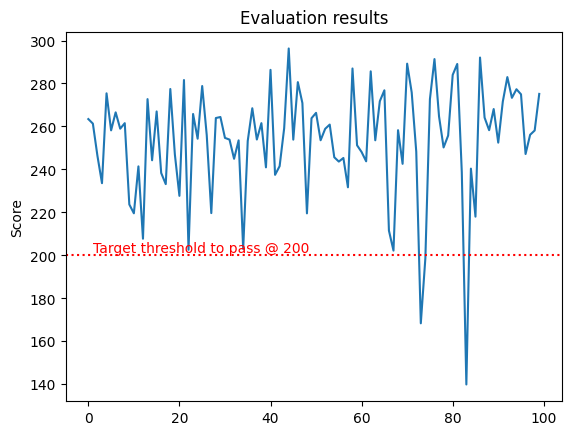

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y)  # Plot the line

# Adding a horizontal dotted red line at y = 200
plt.axhline(y=200, color='r', linestyle=':')

# Adding text near the horizontal line
plt.text(x=1, y=200, s='Target threshold to pass @ 200', color='r', verticalalignment='bottom')

# Adding title and labels
plt.title('Evaluation results')
# plt.xlabel('X Axis Label')
plt.ylabel('Score')

# Show the plot
plt.show()

In [ ]:
# Find elements greater than the threshold
greater_than_threshold = y > 200

# Calculate the ratio of elements greater than the threshold
ratio = np.sum(greater_than_threshold) / len(y)

print(f"Ratio of elements pass target threshold: {ratio*100:.2f}%")
print(f"Ratio of elements fail target threshold: {100-ratio*100:.2f}%")

Ratio of elements pass target threshold: 97.00%
Ratio of elements fail target threshold: 3.00%


# Hyperameters tuning

Hyperameters values research impleneted with **wandb.ai**

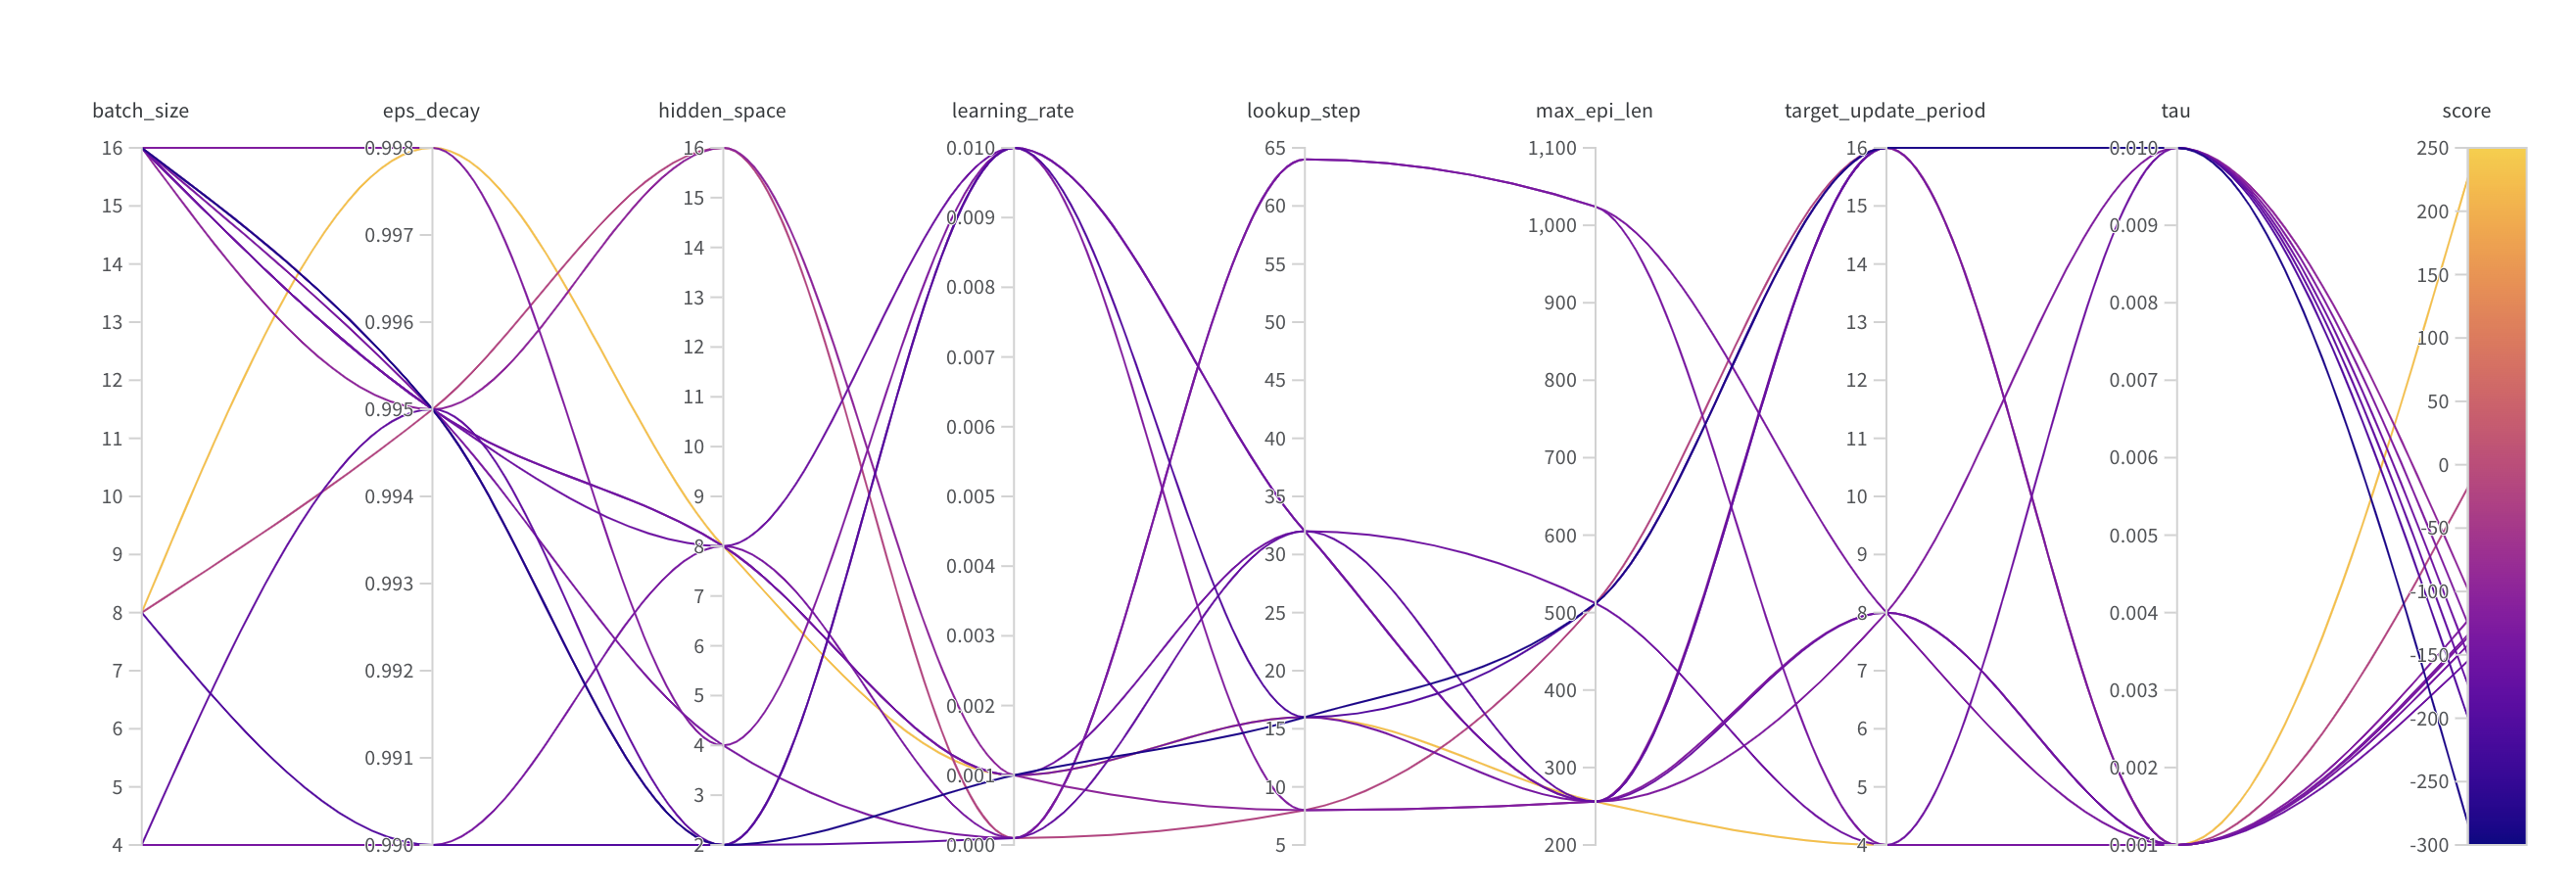

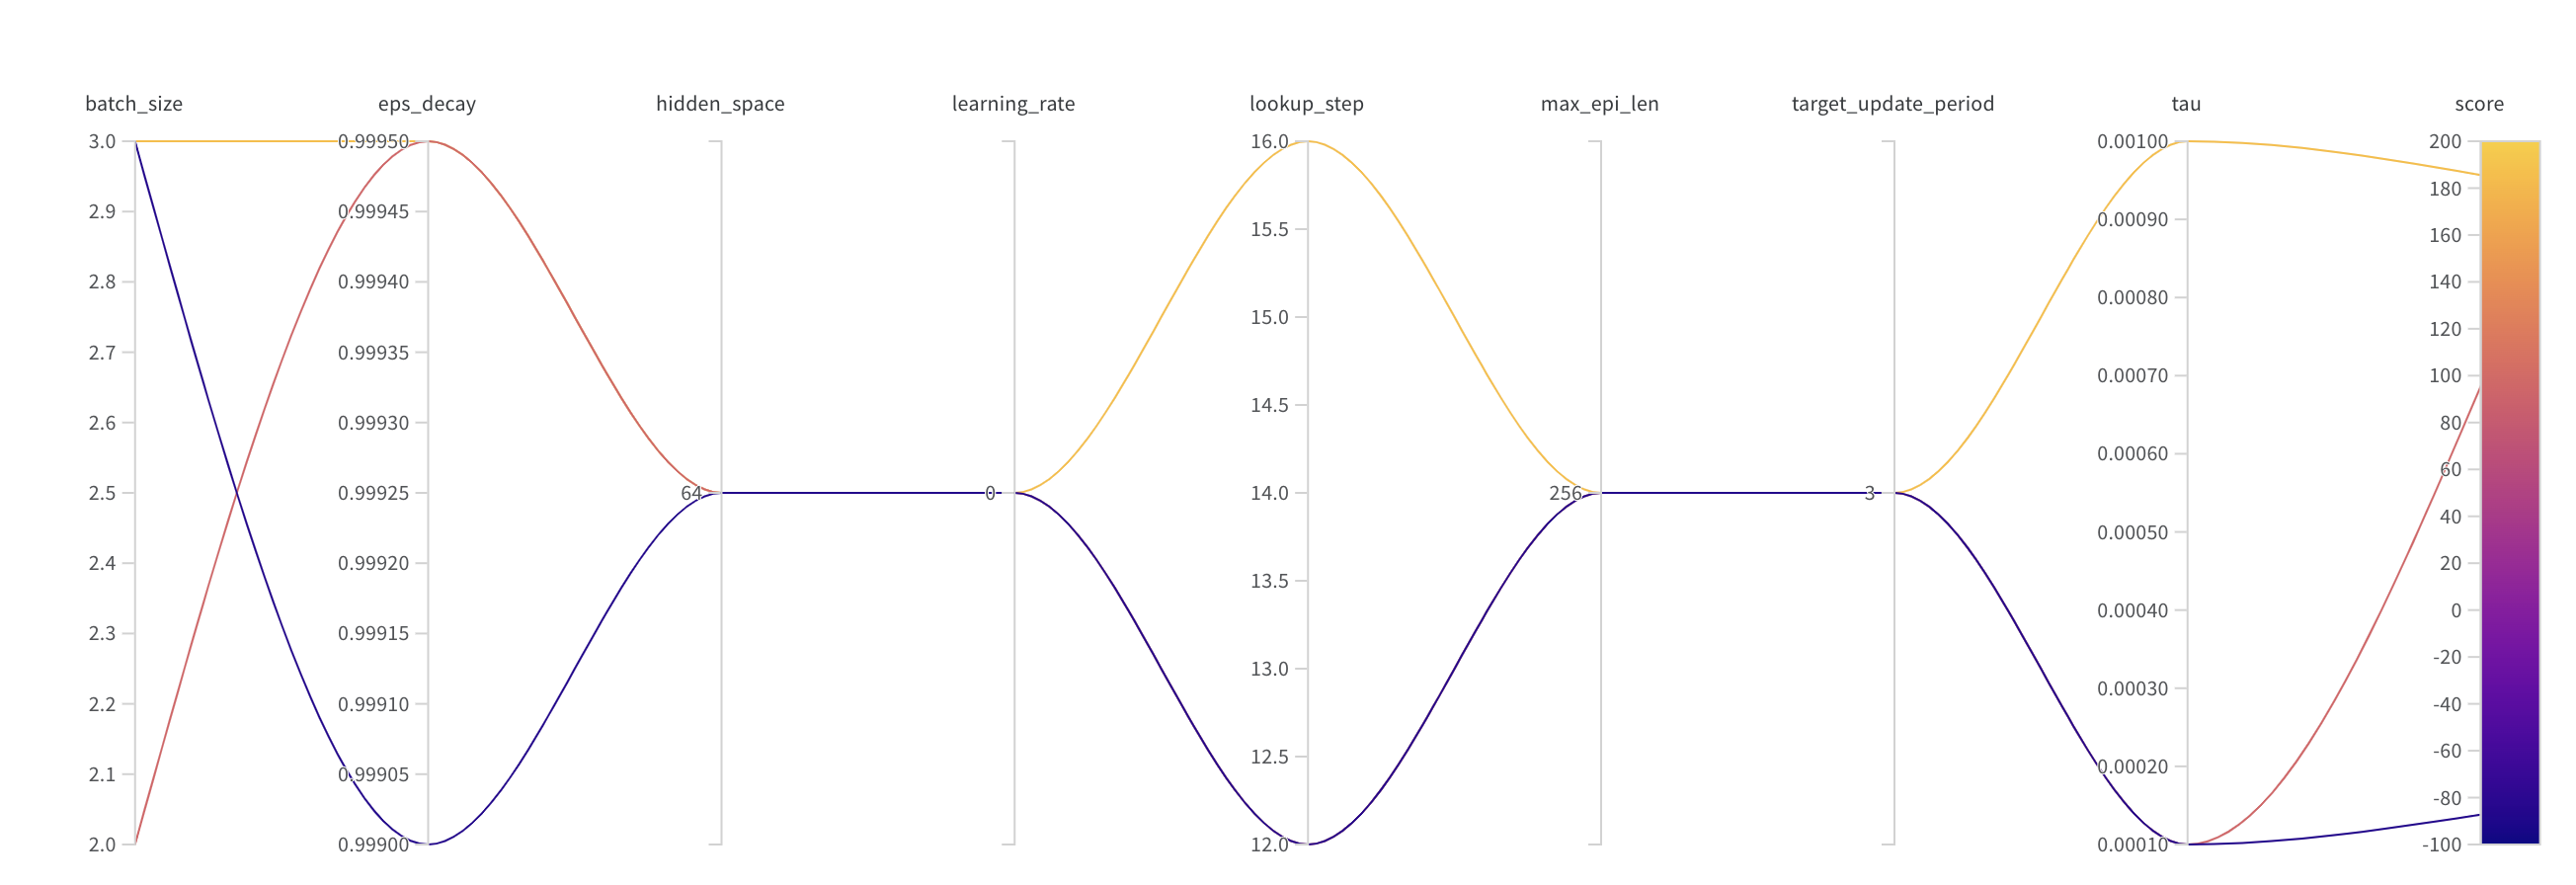


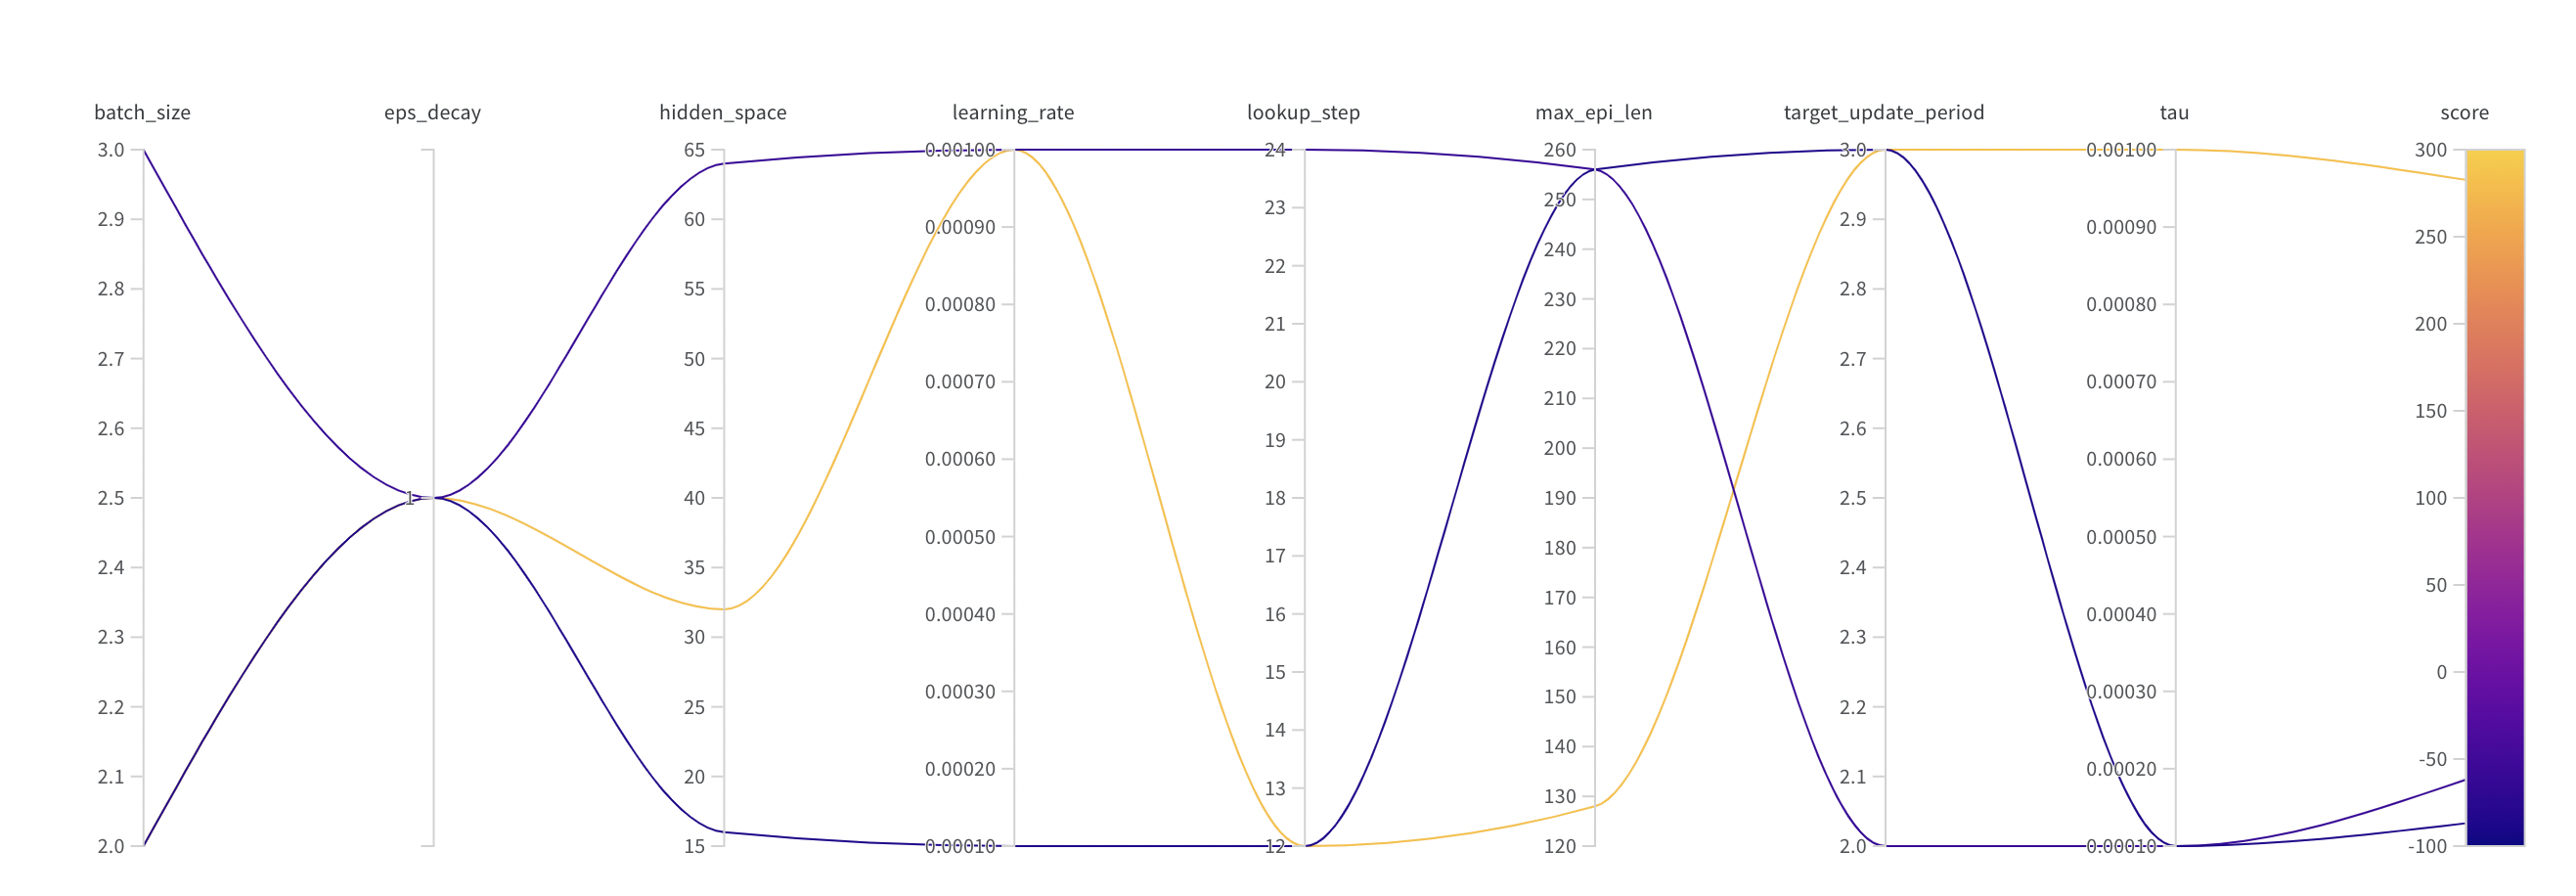

Findings:
* It seems crutial to use high values >0.999 of `eps_decay` for long enougth exploration
* lookup_step between 12 and 16
* hidden_space between 8 and 64
* batch_size [2..8]
* leraning_rate 0.001
* target_update_period 3 or 4
* max_epi_len [128..256]

# Possible ways to improve the model
* **Attention Mechanisms**: Incorporation of attention mechanisms will help the network focus on important parts of the input sequences.
* **Stack More LSTM Layers**: Addiing more LSTM layers or increase the number of hidden units to potentially capture more complex temporal patterns in the data.
* **Bidirectional LSTM**: Bidirectional LSTMs implementation will to learn dependencies from both past and future states, which could provide a richer representation of the environment.
* **Gradient clipping** during the training updates will help to prevent exploding gradients.
* **Generalization**: Incorporation of dropout or regularization within the LSTM layers will help mitigate the risk of overfitting to specific environment dynamics
* **Try GRU** which might offer better training stability compared to LSTM.
* **Advanced Exploration Techniques**: Beyond epsilon-greedy, methods like Upper Confidence Bound (UCB) or Thompson Sampling can be implemented for more effective exploration of the action space.
* **Noisy Networks**: Implementation of noisy networks to replace the need for explicit exploration variables like epsilon.
* **Prioritized Experience Replay**: Modifation of the replay buffer to prioritize important transitions can lead to faster learning.
* **Double Q-Learning**: Integration of Double Q-learning will reduce overestimations of Q-values by decoupling selection and evaluation of the action in the Q-update equation.
* **Alternative Loss Functions**: Experimentation with different loss functions.
* **Adaptive Learning Rates**: Usage of learning rate schedulers to adjust the learning rate based on training progress.
* **Advanced Optimizers**: Testing of different optimizers like RMSprop or SGD with momentum, which might be more effective.


